# Run an update to the masks of COGs on s3  

Paul Montesano, PhD  

Apply a single value from a `mask_fn` to a `src_fn` and write out as a COG.  

Used to post-process data for which a single extra mask value needs to be applied.

In [1]:
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')

import CovariateUtils
from CovariateUtils import write_cog, get_index_tile, get_shape, reader
import build_stack

# import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import geopandas as gpd
import pandas as pd
import s3fs

import rasterio
from rasterio.plot import show_hist, show

In [2]:
from mosaiclib import *

In [16]:
boreal_tiles = gpd.read_file(boreal_tile_index_path)
weird_tiles_df = pd.read_csv('/projects/shared-buckets/lduncanson/local_output/inconsistent_AGB_LC_dim.csv')
#boreal_tiles.explore()

<Axes: >

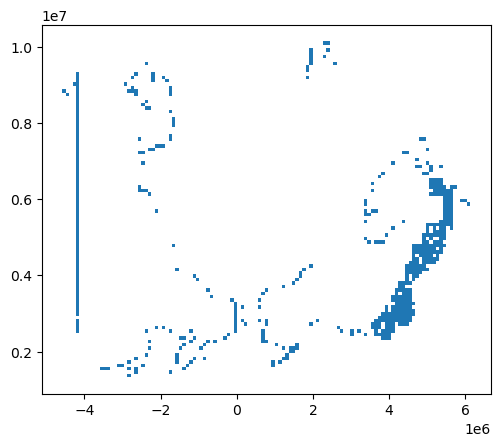

In [20]:
boreal_tiles[boreal_tiles.tile_num.isin(weird_tiles_df.tindex.to_list())].plot()

In [21]:
boreal_tiles[boreal_tiles.tile_num.isin(weird_tiles_df.tindex.to_list())].explore(m=boreal_tiles.explore(color='red'))

In [4]:
[print(var) for var in locals() if 'TINDEX_FN' in var]

ATL08_GRANULE_TINDEX_FN_DICT
ATL08_FILT_TINDEX_FN_DICT
AGB_TINDEX_FN_DICT
HT_TINDEX_FN_DICT
HLS_TINDEX_FN_DICT
SAR_TINDEX_FN_DICT
LC_TINDEX_FN_DICT
TOPO_TINDEX_FN_DICT


[None, None, None, None, None, None, None, None]

In [5]:
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
from mosaiclib import *

In [6]:
AGB_TINDEX_FN_DICT

{'2019_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2019/2019_fullboreal_2019lidar/AGB_tindex_master.csv',
 '2020_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2020/atl08_v6_fullboreal_min5000_90p_local/AGB_tindex_master.csv',
 '2021_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/AGB_tindex_master.csv',
 '2022_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2022/2022_fullboreal_2022lidar/AGB_tindex_master.csv',
 '2023_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2023/2023_full_2023lidar/AGB_tindex_master.csv',
 '2020_v2.0': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master.csv'}

In [7]:
LC_TINDEX_FN_DICT

{'c2020orig': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/LC/LC_tindex_master.csv',
 'c2020updated': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/LC_tindex_master.csv'}

In [20]:
z = pd.read_csv( 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/LC_tindex_master.csv')
z.head()

index                                            s3_path  \
0      0  s3://maap-ops-workspace/montesano/dps_output/r...   
1      1  s3://maap-ops-workspace/montesano/dps_output/r...   
2      2  s3://maap-ops-workspace/montesano/dps_output/r...   
3      3  s3://maap-ops-workspace/montesano/dps_output/r...   
4      4  s3://maap-ops-workspace/montesano/dps_output/r...   

                                          local_path  \
0  /projects/my-private-bucket/dps_output/run_bui...   
1  /projects/my-private-bucket/dps_output/run_bui...   
2  /projects/my-private-bucket/dps_output/run_bui...   
3  /projects/my-private-bucket/dps_output/run_bui...   
4  /projects/my-private-bucket/dps_output/run_bui...   

                                      file  tile_num        creation time  
0  esa_worldcover_v100_2020_354000_cog.tif    354000  2024-01-10 09:57:35  
1  esa_worldcover_v100_2020_382300_cog.tif    382300  2024-01-10 09:57:00  
2  esa_worldcover_v100_2020_363400_cog.tif    363400  2024-01-10 09:56:51  
3    esa_worldcover_v100_2020_3916_cog.tif      3916  2024-01-10 09:49:38  
4    esa_worldcover_v100_2020_4004_cog.tif      4004  2024-01-10 09:49:22

### Get a pair of AGB and LC COGs for a focal tile to test

In [22]:
# def get_fn_list(tindex_src_fn, tindex_mask_fn, path_col, FOCAL_TILE=None):
    
#     list_fn_pairs = []
#     tindex_src = pd.read_csv(tindex_src_fn)
#     tindex_mask = pd.read_csv(tindex_mask_fn)
    
#     if FOCAL_TILE is not None:
#         TILE_LIST = [FOCAL_TILE]
#     else:
#         TILE_LIST = tindex_src.tile_num.to_list()
        
#     for FOCAL_TILE in TILE_LIST:
#         src_fn = tindex_src[tindex_src.tile_num == FOCAL_TILE][path_col].to_list()[0]
#         mask_fn = tindex_mask[tindex_mask.tile_num == FOCAL_TILE][path_col].to_list()[0]
#         list_fn_pairs.append((src_fn, mask_fn))
    
#     return list_fn_pairs      

In [9]:
def get_tile_fn_list(tindex_fn_list, path_col, FOCAL_TILE=None):
    
    list_fn_pairs = []
    
    if FOCAL_TILE is not None:
        TILE_LIST = [FOCAL_TILE]
    else:
        tindex_first = pd.read_csv(tindex_fn_list[0])
        TILE_LIST = tindex_first.tile_num.to_list()
        
    for FOCAL_TILE in TILE_LIST:
        focal_tile_fn_list = []
        for tindex_fn in tindex_fn_list:
            tindex = pd.read_csv(tindex_fn)
            r_fn = tindex[tindex.tile_num == FOCAL_TILE][path_col].to_list()[0]
            focal_tile_fn_list += [r_fn]
        list_fn_pairs.append(focal_tile_fn_list)
    
    return list_fn_pairs  

In [10]:
FOCAL_TILE = 3823
FOCAL_TILE = 3916
#FOCAL_TILE = 34447

In [11]:
src_fn, mask_fn, hls_fn, topo_fn = get_tile_fn_list([AGB_TINDEX_FN_DICT['2021_v1.9'], LC_TINDEX_FN_DICT['c2020updated'], HLS_TINDEX_FN_DICT['2023'], TOPO_TINDEX_FN_DICT['c2020updated_v2']], 's3_path', FOCAL_TILE=FOCAL_TILE)[0]

In [12]:
hls_fn

's3://maap-ops-workspace/montesano/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/HLS_H30_2023/mc25_07-01_08-31_2023_2023/2024/01/10/21/00/14/345743/HLS_3916_07-01_08-31_2023_2023.tif'

In [109]:
# fn = 's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/2024/04/22/09/01/16/554417/boreal_agb_202404221713801660_034447.tif'
# r_ds = rasterio.open(fn)
# print(r_ds.shape)

In [13]:
build_stack.check_dims([src_fn, mask_fn, hls_fn, topo_fn])

s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/2024/04/22/09/50/52/138768/boreal_agb_202404221713804585_003916.tif: (2, 3145, 2847)
s3://maap-ops-workspace/montesano/dps_output/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/2024/01/10/09/49/34/348073/esa_worldcover_v100_2020_3916_cog.tif: (1, 3000, 2716)
s3://maap-ops-workspace/montesano/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/HLS_H30_2023/mc25_07-01_08-31_2023_2023/2024/01/10/21/00/14/345743/HLS_3916_07-01_08-31_2023_2023.tif: (21, 3145, 2847)
s3://maap-ops-workspace/montesano/dps_output/run_build_stack_topo/build_stack_v2024_2/CopernicusGLO30/2024/07/09/16/30/12/691935/CopernicusGLO30_3916_cog_topo_stack.tif: (5, 3000, 2715)


In [92]:
src_fn, mask_fn, hls_fn, topo_fn = get_tile_fn_list([AGB_TINDEX_FN_DICT['2020_v2.0'], LC_TINDEX_FN_DICT['c2020updated'], HLS_TINDEX_FN_DICT['2023'], TOPO_TINDEX_FN_DICT['c2020updated_v2']], 's3_path', FOCAL_TILE=FOCAL_TILE)[0]

In [104]:
build_stack.check_dims([src_fn, mask_fn, hls_fn, topo_fn, '/projects/my-private-bucket/tmp/HLS_3823_07-01_08-31_2020_2020.tif'])

s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/2024/04/22/09/01/16/554417/boreal_agb_202404221713801660_034447.tif: (2, 1500, 3000)
s3://maap-ops-workspace/montesano/dps_output/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/2023/12/07/06/29/02/787022/esa_worldcover_v100_2020_34447_cog.tif: (1, 3000, 3000)
s3://maap-ops-workspace/montesano/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/HLS_H30_2021/mc25_07-01_08-31_2021_2021/2024/03/17/18/05/16/224327/HLS_34447_07-01_08-31_2021_2021.tif: (21, 3000, 3000)
s3://maap-ops-workspace/montesano/dps_output/run_build_stack_topo/build_stack_v2024_2/CopernicusGLO30/2024/07/09/16/39/49/071952/CopernicusGLO30_34447_cog_topo_stack.tif: (5, 3000, 3000)


RasterioIOError: '/projects/my-private-bucket/tmp/HLS_3823_07-01_08-31_2020_2020.tif' not recognized as a supported file format.

In [67]:
src_fn

's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/2024/07/17/10/55/56/546731/boreal_agb_202407171721238848_003916.tif'

In [68]:
mask_fn

's3://maap-ops-workspace/montesano/dps_output/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/2024/01/10/09/49/34/348073/esa_worldcover_v100_2020_3916_cog.tif'

In [69]:
s3_anon = s3 = s3fs.S3FileSystem(anon=True)
DIR_LOCAL = '/projects/my-public-bucket/local_output/mask_cogs'

In [70]:
s3_anon.download(src_fn, DIR_LOCAL)
s3_anon.download(mask_fn, DIR_LOCAL)

[None]

### Update the mask of the AGB COG for the focal tile

In [97]:
import importlib
importlib.reload(build_stack)

<module 'build_stack' from '/projects/code/icesat2_boreal/lib/build_stack.py'>

In [72]:
out_cog_fn = build_stack.mask_cog([os.path.join(DIR_LOCAL, os.path.basename(src_fn)), os.path.join(DIR_LOCAL, os.path.basename(mask_fn))], mask_val_list=[60])

(2, 3145, 2847)
\mask_arr shape: (3000, 2716)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3145 but corresponding boolean dimension is 3000

### Check the difference between the original and updated

In [38]:
diff_cog = build_stack.diff_cogs(os.path.join(DIR_LOCAL, os.path.basename(src_fn)), out_cog_fn, FOCAL_TILE, DIR_LOCAL, diff_id_name='diff_masked', bnum=1, ndv=-9999, units='mg_ha')

Opening /projects/my-public-bucket/local_output/mask_cogs/boreal_agb_202407171721247672_003082.tif
no data value is nan
Opening /projects/my-public-bucket/local_output/mask_cogs/boreal_agb_202407171721247672_003082_masked.tif
no data value is None
Shape of input:			 (1, 3000, 3000)
Resampling:			 0	[0=nearest, 1=blinear, 2=cubic]
Output resolution:		 (30, 30)
Writing img to memory...
Current stack shape:		(1,3000,3000)


/projects/code/icesat2_boreal/lib/build_stack.py:207: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/f2aa8531-c62e-48a1-bb89-a046641edc85/f2aa8531-c62e-48a1-bb89-a046641edc85.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/local_output/mask_cogs/diff_masked_0003082.tif


Image written to disk:		 /projects/my-public-bucket/local_output/mask_cogs/diff_masked_0003082.tif


### Plot

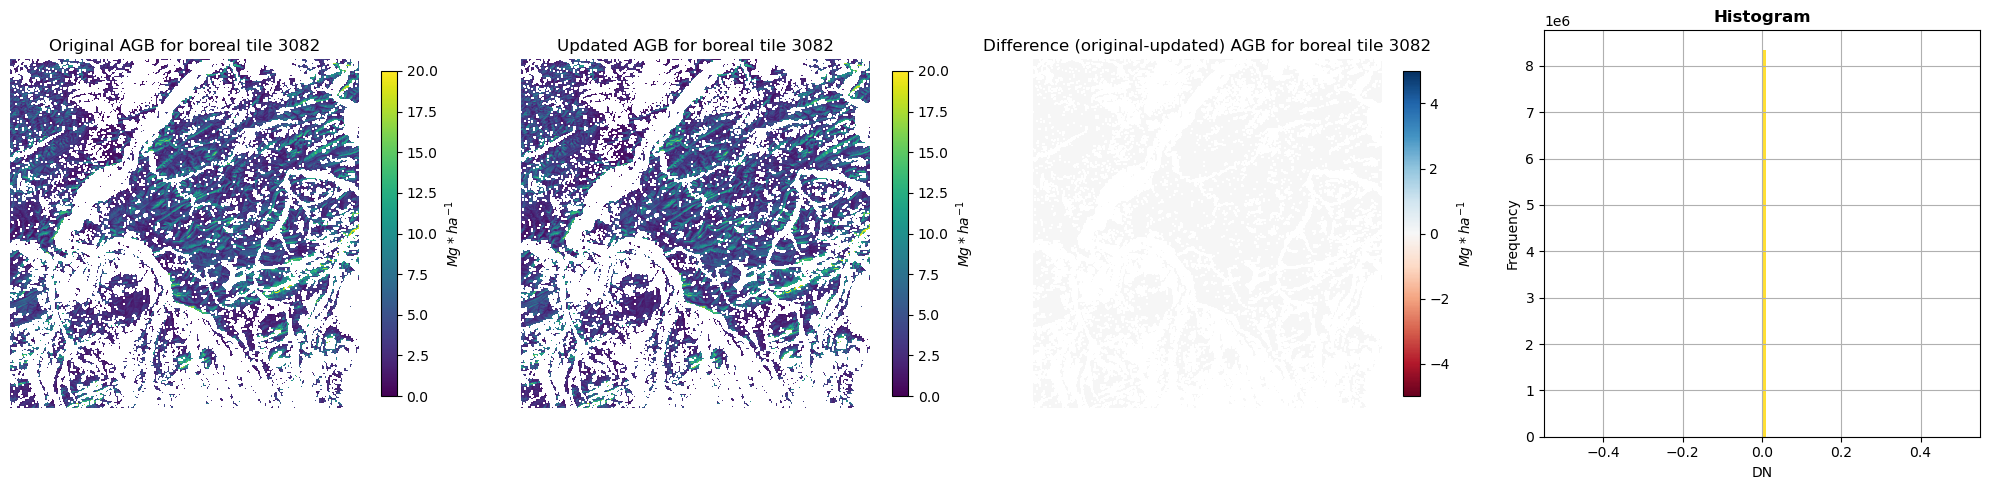

In [57]:
raster_paths = [os.path.join(DIR_LOCAL, os.path.basename(src_fn)), out_cog_fn, diff_cog]  # Replace with your file paths
raster_names = ['Original', 'Updated','Difference (original-updated)']
CMAP_LIST = ['viridis','viridis','RdBu']
CLIM_LIST = [(0,20),(0,20),(-5,5)]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(raster_paths)+1, figsize=(20, 5))

# If there's only one raster, ensure axes is iterable
if len(raster_paths) == 1:
    axes = [axes]

# Loop through each raster and plot it
for i, raster_path in enumerate(raster_paths):
    VMIN, VMAX = CLIM_LIST[i]
    CMAP = CMAP_LIST[i]
    with rasterio.open(raster_path) as src:
        # Read the first band
        arr = src.read(1)
        ax = axes[i]
        image_hidden = ax.imshow(arr, cmap=CMAP, vmax=VMAX, vmin=VMIN)
        ax.imshow(arr, cmap=CMAP, vmax=VMAX, vmin=VMIN)

        # add colorbar using the now hidden image
        cbar = fig.colorbar(image_hidden, ax=ax, shrink=0.8)
        cbar.set_label('$Mg*ha^{-1}$', rotation=90)
        
        # Add title to each subplot
        ax.set_title(f'{raster_names[i]} AGB for boreal tile {FOCAL_TILE}')
        
        # Remove axis ticks
        ax.axis('off')
        
with rasterio.open(diff_cog) as ds:
    rasterio.plot.show_hist(ds.read()[0], ax=axes[-1], bins=100, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.8)
    axes[-1].get_legend().remove()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
import rioxarray as rxa
import math

In [37]:
rds_orig = rxa.open_rasterio(src_fn, masked=True)
valid_px_count = int(rds_orig.count().compute())
total_px_count = rds_orig.size
nodata_px_count_rds_orig = total_px_count - valid_px_count
nodata_px_count_rds_orig

1244370

In [38]:
rds_updated = rxa.open_rasterio(out_cog_fn, masked=True)
valid_px_count = int(rds_updated.count().compute())
total_px_count = rds_updated.size
nodata_px_count_rds_updated = total_px_count - valid_px_count
nodata_px_count_rds_updated

1301454

In [39]:
new_cnt_per_band = int((nodata_px_count_rds_updated-nodata_px_count_rds_orig) / rds_orig.shape[0])

print(f'Tile update masked an additional {new_cnt_per_band} pixels ({round(new_cnt_per_band/total_px_count*100, 2)}%)')

Tile update masked an additional 28542 pixels (0.16%)


# Multiprocess the mask update to AGB and Height COGs on s3 

[1] Test:
    - apply this mask as a multiprocess with a write to `my-private-bucket` from within a workspace owned by Laura
         - with overwrite=False
         - with overwrite=True
         - 

In [1]:
from multiprocessing import Pool
from functools import partial

### Choose some set of raster tiles made for this project
Here, we're using a small set of test topo tiles

In [23]:
TINDEX_FN_FOR_MASK = '/projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/Topo_tindex_master.csv'

### Get the corresponding file names
#### Note: we need to use the column of the tindex that specifies the `local_path` and not the `s3_path` in order to write to subdirs of `my-private-bucket` from these notebooks

In [36]:
list_of_fn_pairs = get_fn_list(TINDEX_FN_FOR_MASK,
                                     LC_TINDEX_FN_DICT['c2020updated'], 
                                     'local_path', # here we specify the local_path column instead of the s3_path column
                                     FOCAL_TILE=3376)
list_of_fn_pairs

[('/projects/my-private-bucket/dps_output/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/2024/01/13/13/49/04/044813/CopernicusGLO30_3376_cog_topo_stack.tif',
  '/projects/my-private-bucket/dps_output/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/2023/12/07/06/31/21/512416/esa_worldcover_v100_2020_3376_cog.tif')]

In [37]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(build_stack.mask_cog, mask_val_list=[60], overwrite=True ), list_of_fn_pairs)

\mask_arr shape: (3000, 3000)
Shape of input:			 (5, 3000, 3000)
Input nodata isnt provided; assuming NaN...
Resampling:			 0	[0=nearest, 1=blinear, 2=cubic]
Output resolution:		 (30, 30)
Writing img to memory...


/projects/code/icesat2_boreal/lib/build_stack.py:157: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(


Current stack shape:		(5,3000,3000)


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/7505f97c-ad9e-4d4a-a555-79b39b7c2b41/7505f97c-ad9e-4d4a-a555-79b39b7c2b41.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-private-bucket/dps_output/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/2024/01/13/13/49/04/044813/CopernicusGLO30_3376_cog_topo_stack.tif


Image written to disk:		 /projects/my-private-bucket/dps_output/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/2024/01/13/13/49/04/044813/CopernicusGLO30_3376_cog_topo_stack.tif


In [38]:
%%time
USER = 'montesano'
ALG_NAME = 'run_build_stack_topo'
ALG_VERSION = 'build_stack_v2023_2'
IDENTIFIER = 'CopernicusGLO30_TEST'
TYPE = 'Topo'


DPS_IDENTIFIER = f"{ALG_VERSION}/{IDENTIFIER}"
DPS_MONTH_LIST = '01'   
DPS_YEAR_LIST = '2024'

DPS_DAY_MIN = 1
OUTDIR = f"/projects/my-public-bucket/DPS_tile_lists/{ALG_NAME}/{DPS_IDENTIFIER}"
!mkdir -p $OUTDIR

# Build tindex
args = f"--RETURN_DUPS \
--user {USER} \
--dps_identifier {DPS_IDENTIFIER} \
-alg_name {ALG_NAME} \
-t {TYPE} \
-y_list {DPS_YEAR_LIST} \
--dps_month_list {DPS_MONTH_LIST} \
-d_min {DPS_DAY_MIN} \
--outdir {OUTDIR}"

!time /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_tindex_master.py $args --WRITE_TINDEX_MATCHES_GDF

NASA MAAP
INFO: Pandarallel will run on 25 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
NASA MAAP

Building a list of tiles:
DPS ID:		build_stack_v2023_2/CopernicusGLO30_TEST
Type:		Topo
Year:		['2024']
Month:		['01']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST
# of duplicate tiles: 1
Final # of tiles: 10
Writing duplicates csv: /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/Topo_tindex_master_duplicates.csv
Writing tindex master csv: /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/Topo_tindex_master.csv
Building geodataframe of matches, tindex master json, and mosaic json...
Tile index matches geodataframe for json: (10, 7)
Building /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusG